In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import subprocess
from tqdm.notebook import tqdm

## Individual Runtimes of Malloc, work, free

In [2]:
# parameters
n_runs = 10
n_warmup = 10
n_blocks = 100
n_threads_per_block = 1024
n_floats = 20

# workloads
workloads = {
    "sum_reduce": 0,
    "prod_reduce": 1,
    "max_reduce": 2,
    "pair_prod" : 3,
    "sum_all_prod": 4
}

In [6]:
def get_mean_std_individual_workloads(n_blocks, n_threads_per_block, n_floats, n_runs, n_warmup, workload):
    cmd_res = subprocess.run(["./a.out", *[str(x) for x in [n_blocks, n_threads_per_block, n_runs, n_warmup, n_floats, workload]]], capture_output=True, text=True)
    cmd_res.check_returncode()
    measurements = [np.fromstring(x, sep=" ") for x in cmd_res.stdout.split("\n")[:15]]
    
    res = []
    for m in measurements:
        res.append(np.mean(m))
        res.append(np.std(m))

    return res

  0%|          | 0/63 [00:00<?, ?it/s]

Martin speedup mean: 1.1083379667427875
Flo speedup mean: 1.0716136170845685
V4 speedup mean: 1.0721274155347615
V5 speedup mean: 1.0541998615924983


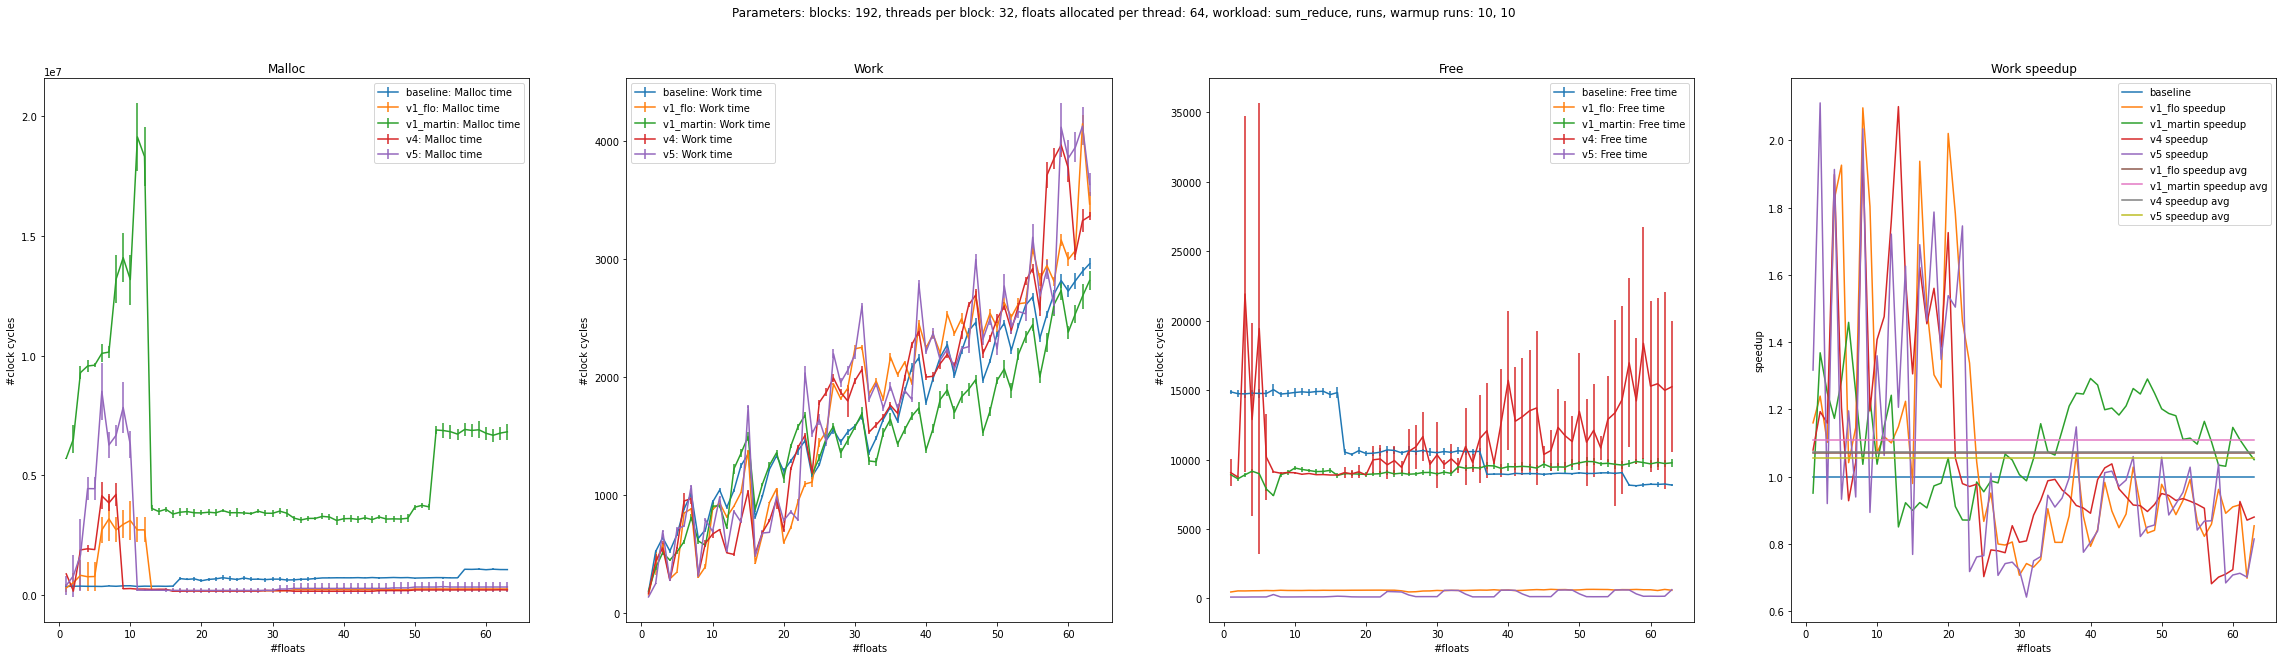

In [4]:
# parameters
n_runs = 10
n_warmup = 10
n_blocks = 192
n_threads_per_block = 32
n_floats = 64
workload = workloads["sum_reduce"]


plt.rcParams['figure.figsize'] = [40, 10]
fig, axs = plt.subplots(1, 4)


# floats = list(np.logspace(0, n_floats, base=2, num=13))
floats = list(range(1, n_floats))
results = []
for n_floats_ in tqdm(floats):
    results.append(get_mean_std_individual_workloads(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block,\
                                          n_floats=n_floats_, n_runs=n_runs, n_warmup=n_warmup, workload=workload))

means_base_malloc_time, stds_base_malloc_time,\
means_base_work_time, stds_base_work_time,\
means_base_free_time, stds_base_free_time,\
means_v1_flo_malloc_time, stds_v1_flo_malloc_time,\
means_v1_flo_work_time, stds_v1_flo_work_time,\
means_v1_flo_free_time, stds_v1_flo_free_time,\
means_v4_malloc_time, stds_v4_malloc_time,\
means_v4_work_time, stds_v4_work_time,\
means_v4_free_time, stds_v4_free_time,\
means_v5_malloc_time, stds_v5_malloc_time,\
means_v5_work_time, stds_v5_work_time,\
means_v5_free_time, stds_v5_free_time\
= zip(*results)
fig.suptitle("Parameters:" \
          + " blocks: " + str(n_blocks)\
          + ", threads per block: " + str(n_threads_per_block)\
          + ", floats allocated per thread: " + str(n_floats)\
          + ", workload: sum_reduce"\
          + ", runs, warmup runs: " + str(n_runs) + ", " + str(n_warmup))

axs[0].set_title("Malloc")
axs[0].errorbar(floats, means_base_malloc_time, stds_base_malloc_time, label="baseline: Malloc time")
axs[0].errorbar(floats, means_v1_flo_malloc_time, stds_v1_flo_malloc_time, label="v1_flo: Malloc time")
axs[0].errorbar(floats, means_v1_martin_malloc_time, stds_v1_martin_malloc_time, label="v1_martin: Malloc time")
axs[0].errorbar(floats, means_v4_malloc_time, stds_v4_malloc_time, label="v4: Malloc time")
axs[0].errorbar(floats, means_v5_malloc_time, stds_v5_malloc_time, label="v5: Malloc time")
axs[0].legend()
axs[0].set_xlabel("#floats")
axs[0].set_ylabel("#clock cycles")
# axs[0].set_xscale("log", base=2)

axs[1].set_title("Work")
axs[1].errorbar(floats, means_base_work_time, stds_base_work_time, label="baseline: Work time")
axs[1].errorbar(floats, means_v1_flo_work_time, stds_v1_flo_work_time, label="v1_flo: Work time")
axs[1].errorbar(floats, means_v1_martin_work_time, stds_v1_martin_work_time, label="v1_martin: Work time")
axs[1].errorbar(floats, means_v4_work_time, stds_v4_work_time, label="v4: Work time")
axs[1].errorbar(floats, means_v5_work_time, stds_v5_work_time, label="v5: Work time")
axs[1].legend()
axs[1].set_xlabel("#floats")
axs[1].set_ylabel("#clock cycles")
# axs[1].set_xscale("log", base=2)

axs[2].set_title("Free")
axs[2].errorbar(floats, means_base_free_time, stds_base_free_time, label="baseline: Free time")
axs[2].errorbar(floats, means_v1_flo_free_time, stds_v1_flo_free_time, label="v1_flo: Free time")
axs[2].errorbar(floats, means_v1_martin_free_time, stds_v1_martin_free_time, label="v1_martin: Free time")
axs[2].errorbar(floats, means_v4_free_time, stds_v4_free_time, label="v4: Free time")
axs[2].errorbar(floats, means_v5_free_time, stds_v5_free_time, label="v5: Free time")
axs[2].legend()
axs[2].set_xlabel("#floats")
axs[2].set_ylabel("#clock cycles")
# axs[2].set_xscale("log", base=2)

flo_speedup = np.asarray(means_base_work_time)/np.asarray(means_v1_flo_work_time)
martin_speedup = np.asarray(means_base_work_time)/np.asarray(means_v1_martin_work_time)
v4_speedup = np.asarray(means_base_work_time)/np.asarray(means_v4_work_time)
v5_speedup = np.asarray(means_base_work_time)/np.asarray(means_v5_work_time)
flo_speedup_mean = np.mean(flo_speedup)
martin_speedup_mean = np.mean(martin_speedup)
v4_speedup_mean = np.mean(v4_speedup)
v5_speedup_mean = np.mean(v5_speedup)

axs[3].set_title("Work speedup")
axs[3].plot(floats, [1 for x in means_base_work_time], label="baseline")
axs[3].plot(floats, flo_speedup, label="v1_flo speedup")
axs[3].plot(floats, martin_speedup, label="v1_martin speedup")
axs[3].plot(floats, v4_speedup, label="v4 speedup")
axs[3].plot(floats, v5_speedup, label="v5 speedup")
axs[3].plot(floats, [flo_speedup_mean for x in floats], label="v1_flo speedup avg")
axs[3].plot(floats, [martin_speedup_mean for x in floats], label="v1_martin speedup avg")
axs[3].plot(floats, [v4_speedup_mean for x in floats], label="v4 speedup avg")
axs[3].plot(floats, [v5_speedup_mean for x in floats], label="v5 speedup avg")
axs[3].legend()
axs[3].set_xlabel("#floats")
axs[3].set_ylabel("speedup")
# axs[3].set_xscale("log", base=2)

print("Martin speedup mean:", martin_speedup_mean)
print("Flo speedup mean:", flo_speedup_mean)
print("V4 speedup mean:", v4_speedup_mean)
print("V5 speedup mean:", v5_speedup_mean)

plt.show()
